11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing



📊 BASELINE MODEL ACCURACY (Before Regressor Growth Adjustments):
🔹 MSE  : 98,168,924,748.06
🔹 RMSE : 313,319.21
🔹 MAE  : 257,849.49
🔹 MAPE : 13.20%

Enter monthly increase/decrease rate for each regressor as a percentage (e.g., 1.5 or -0.5):


11:46:03 - cmdstanpy - INFO - Chain [1] start processing
11:46:03 - cmdstanpy - INFO - Chain [1] done processing


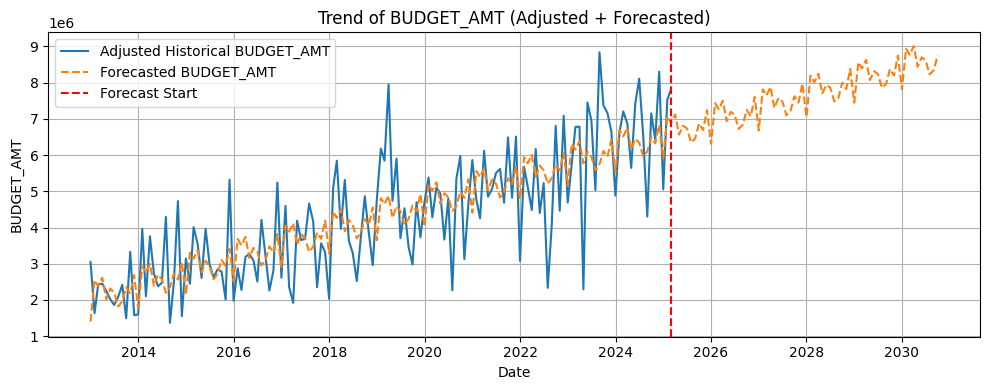

11:46:03 - cmdstanpy - INFO - Chain [1] start processing
11:46:03 - cmdstanpy - INFO - Chain [1] done processing


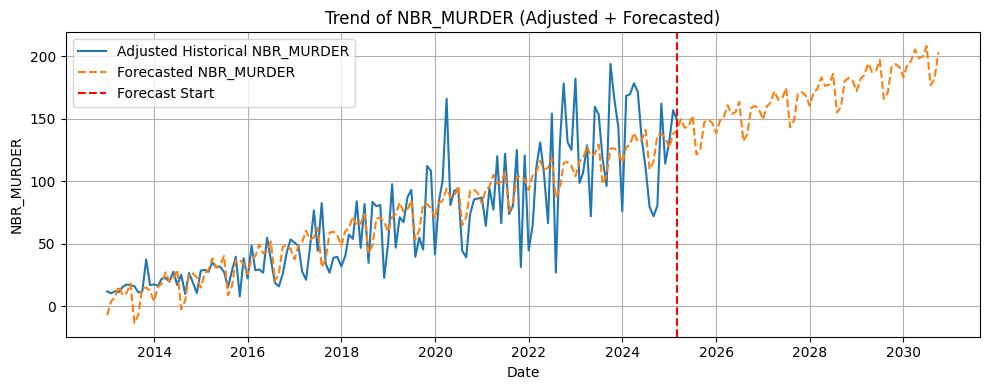

11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:04 - cmdstanpy - INFO - Chain [1] done processing



 ADJUSTED MODEL ACCURACY (After Regressor Growth Adjustments):
🔹 MSE  : 1,394,567,912,798.56
🔹 RMSE : 1,180,918.25
🔹 MAE  : 928,875.94
🔹 MAPE : 49.25%


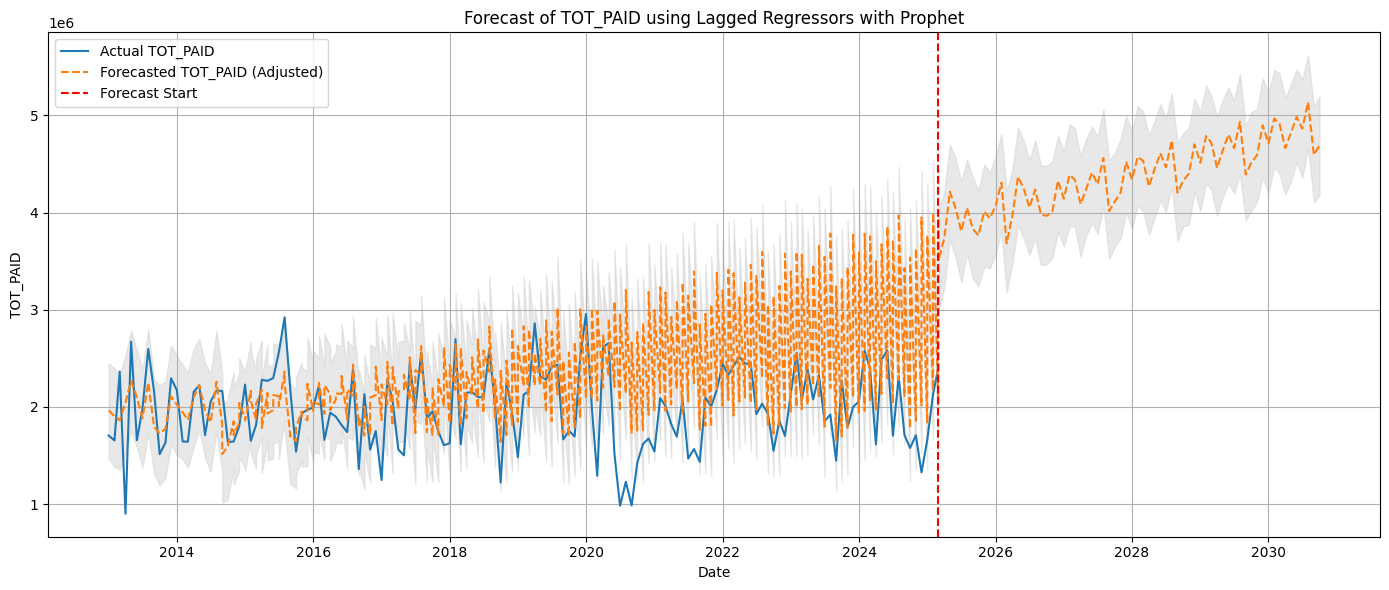


 Forecasted TOT_PAID for next 18 months:
            ds          yhat    yhat_lower    yhat_upper
274 2025-03-01  3.506737e+06  2.976731e+06  4.018257e+06
275 2025-04-01  3.734332e+06  3.227297e+06  4.216688e+06
276 2025-05-01  4.214709e+06  3.725498e+06  4.699861e+06
277 2025-06-01  4.042070e+06  3.533905e+06  4.557265e+06
278 2025-07-01  3.807472e+06  3.283319e+06  4.320051e+06
279 2025-08-01  4.047291e+06  3.576839e+06  4.545999e+06
280 2025-09-01  3.830536e+06  3.323344e+06  4.362037e+06
281 2025-10-01  3.764526e+06  3.242019e+06  4.225310e+06
282 2025-11-01  4.010367e+06  3.443214e+06  4.498341e+06
283 2025-12-01  3.941259e+06  3.426752e+06  4.412837e+06
284 2026-01-01  4.070113e+06  3.570961e+06  4.579773e+06
285 2026-02-01  4.306677e+06  3.811726e+06  4.804138e+06
286 2026-03-01  3.682305e+06  3.174777e+06  4.226127e+06
287 2026-04-01  3.972945e+06  3.474177e+06  4.440015e+06
288 2026-05-01  4.370167e+06  3.875669e+06  4.876409e+06
289 2026-06-01  4.245309e+06  3.730026e+06  4.

In [39]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# === Step 1: Load and prepare the data ===
df = pd.read_csv("C:/GitHub/Machine-Learning/data/BCM_DATA.csv", parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']

# === Step 2: Create lagged regressors ===
df['BUDGET_AMT_lag12'] = df['BUDGET_AMT'].shift(12)
df['NBR_MURDER_lag20'] = df['NBR_MURDER'].shift(20)

# Drop rows with NA due to lagging
df = df.dropna(subset=['BUDGET_AMT_lag12', 'NBR_MURDER_lag20'])

# Final regressor names to use
regressors = ['BUDGET_AMT_lag12', 'NBR_MURDER_lag20']

# === Step 3: Train/Test Split (80% train, 20% test) ===
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()
test_dates = test_df['ds']

# === Step 4: Accuracy BEFORE applying growth rates ===
model_baseline = Prophet(yearly_seasonality=True)
for reg in regressors:
    model_baseline.add_regressor(reg)
model_baseline.fit(train_df)

# Use real lagged data (no regressor forecast)
full_input_baseline = pd.concat([train_df, test_df], axis=0)
forecast_baseline = model_baseline.predict(full_input_baseline)

# Evaluate on test data
pred_test_base = forecast_baseline[forecast_baseline['ds'].isin(test_dates)].copy()
actual_test_base = test_df.set_index('ds').loc[pred_test_base['ds']]
y_true_base = actual_test_base['y'].values
y_pred_base = pred_test_base['yhat'].values

mse_base = mean_squared_error(y_true_base, y_pred_base)
rmse_base = np.sqrt(mse_base)
mae_base = mean_absolute_error(y_true_base, y_pred_base)
mape_base = np.mean(np.abs((y_true_base[y_true_base != 0] - y_pred_base[y_true_base != 0]) / y_true_base[y_true_base != 0])) * 100

print("\n📊 BASELINE MODEL ACCURACY (Before Regressor Growth Adjustments):")
print(f"🔹 MSE  : {mse_base:,.2f}")
print(f"🔹 RMSE : {rmse_base:,.2f}")
print(f"🔹 MAE  : {mae_base:,.2f}")
print(f"🔹 MAPE : {mape_base:.2f}%")

# === Step 5: Get user input for growth rates ===
print("\nEnter monthly increase/decrease rate for each regressor as a percentage (e.g., 1.5 or -0.5):")
budget_growth = float(input("BUDGET_AMT monthly change rate (%): ")) / 100
murder_growth = float(input("NBR_MURDER monthly change rate (%): ")) / 100

growth_map = {
    'BUDGET_AMT': budget_growth,
    'NBR_MURDER': murder_growth
}

# === Step 6: Forecast base regressors with growth ===
base_future_periods = len(test_df) + 18 + 20  # buffer for forecast + lag
regressor_forecasts = {}

for base_reg in ['BUDGET_AMT', 'NBR_MURDER']:
    reg_df = df[['ds', base_reg]].rename(columns={base_reg: 'y'}).copy()

    # Apply increase/decrease as linear percentage change over time
    base_series = reg_df['y'].values
    change_rate = growth_map[base_reg]  # this is the user input % as decimal

    adjusted_series = [base_series[i] * (1 + i * change_rate) for i in range(len(base_series))]
    reg_df['y'] = adjusted_series

    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    reg_future = reg_model.make_future_dataframe(periods=base_future_periods, freq='MS')
    reg_forecast = reg_model.predict(reg_future)

    regressor_forecasts[base_reg] = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': base_reg})

    # Plot regressor trend
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Adjusted Historical {base_reg}')
    plt.plot(reg_forecast['ds'], reg_forecast['yhat'], '--', label=f'Forecasted {base_reg}')
    plt.axvline(x=df['ds'].max(), color='red', linestyle='--', label='Forecast Start')
    plt.title(f'Trend of {base_reg} (Adjusted + Forecasted)')
    plt.xlabel('Date')
    plt.ylabel(base_reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 7: Merge and apply lags ===
forecast_df = regressor_forecasts['BUDGET_AMT'].merge(
    regressor_forecasts['NBR_MURDER'], on='ds'
)

# Apply lags
forecast_df['BUDGET_AMT_lag12'] = forecast_df['BUDGET_AMT'].shift(12)
forecast_df['NBR_MURDER_lag20'] = forecast_df['NBR_MURDER'].shift(20)

# Drop rows without full lags
forecast_df = forecast_df.dropna(subset=['BUDGET_AMT_lag12', 'NBR_MURDER_lag20'])

# === Step 8: Prepare full input ===
historic_lagged = df[['ds', 'y', 'BUDGET_AMT_lag12', 'NBR_MURDER_lag20']]
combined = pd.concat([historic_lagged, forecast_df[['ds', 'BUDGET_AMT_lag12', 'NBR_MURDER_lag20']]], ignore_index=True)

# === Step 9: Train Prophet model on train data ===
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)

model.fit(train_df)

# === Step 10: Forecast across full horizon ===
full_forecast = model.predict(combined)

# === Step 11: Model Accuracy Evaluation (Post-adjustment) ===
predicted_test = full_forecast[full_forecast['ds'].isin(test_dates)].copy()
actual_test = test_df.set_index('ds').loc[predicted_test['ds']]
y_true = actual_test['y'].values
y_pred = predicted_test['yhat'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
non_zero_idx = y_true != 0
mape = np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

print("\n ADJUSTED MODEL ACCURACY (After Regressor Growth Adjustments):")
print(f"🔹 MSE  : {mse:,.2f}")
print(f"🔹 RMSE : {rmse:,.2f}")
print(f"🔹 MAE  : {mae:,.2f}")
print(f"🔹 MAPE : {mape:.2f}%")

# === Step 12: Final Forecast Plot ===
last_date = df['ds'].max()
forecast_future = full_forecast[full_forecast['ds'] > last_date][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(18)

plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Actual TOT_PAID')
plt.plot(full_forecast['ds'], full_forecast['yhat'], label='Forecasted TOT_PAID (Adjusted)', linestyle='--')
plt.fill_between(full_forecast['ds'], full_forecast['yhat_lower'], full_forecast['yhat_upper'], color='lightgray', alpha=0.5)
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title('Forecast of TOT_PAID using Lagged Regressors with Prophet')
plt.xlabel('Date')
plt.ylabel('TOT_PAID')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 13: Print Forecasted Values ===
print("\n Forecasted TOT_PAID for next 18 months:")
print(forecast_future)


12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing


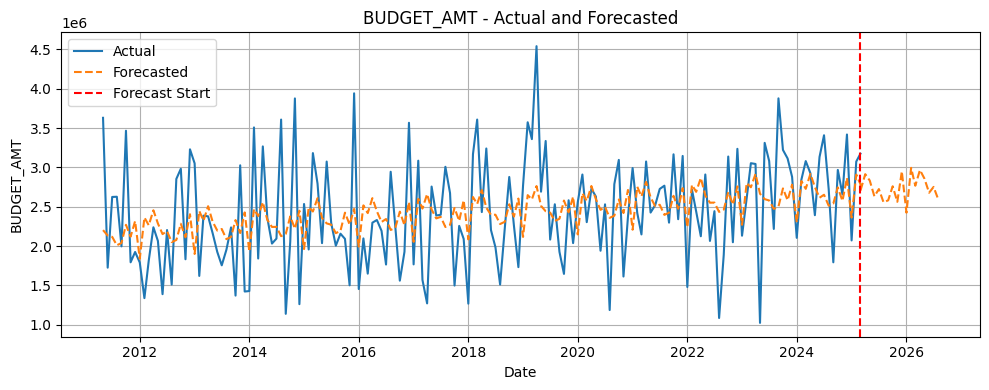

12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing


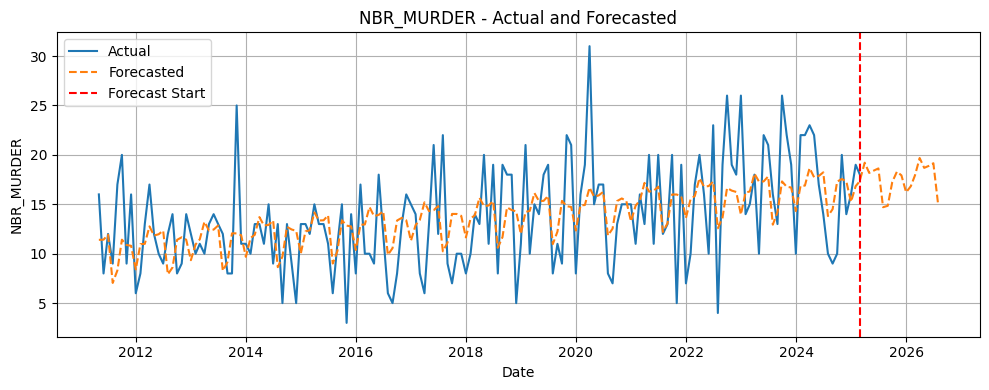

12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.